# LGBM을 활용한 베이스라인

In [55]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split

import lightgbm as lgb
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## 1. 데이터 로딩

In [184]:
main_df = pd.read_csv("/opt/ml/input/data/train/train_ratings.csv")

## 2. 데이터셋 만들기

In [ ]:
# set(list(main_df.groupby('user')['item'])[0][1]) #11번 유저가 본 아이템들

In [43]:
main_df['rating'] = 1
main_df = main_df.drop(columns='time', axis=1)

In [45]:
main_df.head(3)

,user,item,rating
0,11,4643,1
1,11,170,1
2,11,531,1


In [46]:
# 3. Negative instance 생성 : 각 유저별 true:false = 5:5, 20분정도 소요
print("Create Nagetive instances")
# num_negative = 50
user_group_dfs = list(main_df.groupby('user')['item'])

first_row = True
items = set(main_df.loc[:, 'item'])

for u, u_items in tqdm(user_group_dfs):
    u_items = set(u_items)                 #해당 유저가 본 아이템
    i_user_neg_item = np.random.choice(list(items - u_items), len(u_items), replace=False)
    
    i_user_neg_df = pd.DataFrame({'user': [u]*len(u_items), 'item': i_user_neg_item, 'rating': [0]*len(u_items)})
    if first_row == True:
        user_neg_dfs = i_user_neg_df
        first_row = False
    else:
        user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

result = pd.concat([main_df, user_neg_dfs], axis = 0, sort=False)
result.to_csv("user_direct_neg_sampling.csv", index=False)
result.isna().sum()

Create Nagetive instances


100%|██████████| 31360/31360 [20:40<00:00, 25.27it/s]


user      0
item      0
rating    0
dtype: int64

In [47]:
result.to_csv("user_item_rating_neg_sampling.csv", index=False)

In [56]:
neg_train_result = result

In [57]:
neg_train_result.shape

(10308942, 3)

In [52]:
ease_result = pd.read_csv('/opt/ml/input/fighting/Recbole/EASE_best.csv')

In [54]:
ease_result.shape

(9408000, 2)

In [58]:
# 차집합 구하기
lgbm_train_df = pd.concat([neg_train_result, ease_result, ease_result]).drop_duplicates(subset=['user', 'item'], keep=False)


In [64]:
lgbm_train_df.shape

(10070694, 3)

In [62]:
lgbm_train_df.to_csv("lgbm_train_df.csv", index=False)

In [60]:
# 10308942 - 10070694 = 약 23만 8천

In [63]:
lgbm_inference_df = ease_result

## 3. Feature Engineering
모듈화 한 피처들을 merge하면 된다.

In [67]:
year_df = pd.read_csv("/opt/ml/input/fighting/FE/year/year_missingno.csv")
genre_df = pd.read_csv("/opt/ml/input/fighting/FE/genre/genre_bert_fe.csv")

In [74]:
train_df = lgbm_train_df.merge(year_df, how='left', on='item')
train_df = train_df.merge(genre_df, how='left', on='item')

In [75]:
train_df.shape

(10070694, 5)

In [76]:
train_df.head(3)

,user,item,rating,year,genre_embedding
0,11,4643,1.0,2001.0,-0.010404
1,11,170,1.0,1995.0,-0.010290
2,11,531,1.0,1993.0,-0.010649


In [77]:
inference_df = lgbm_inference_df.merge(year_df, how='left', on='item')
inference_df = inference_df.merge(genre_df, how='left', on='item')

In [78]:
inference_df.shape

(9408000, 4)

In [79]:
inference_df.head(3)

,user,item,year,genre_embedding
0,11,4370,2001.0,-0.010420
1,11,4886,2001.0,-0.010383
2,11,47,1995.0,-0.010262


In [94]:
inference_df = test_df

## 4. LGBM Train/Test 데이터 셋

In [108]:
# user별 interaction을 8:2로 split code
# 하루종일 걸릴 것 같다.. (예상시간 12시간 넘었음)

# import random

# def custom_train_test_split(df, ratio=0.8):
#     # user별 interaction을 8:2로 split
#     user_group_dfs = list(df.groupby('user')['item'])

#     first_row = True
#     items = set(df.loc[:, 'item']) #아이템 개수 6807

#     for u, u_items in tqdm(user_group_dfs):
        
#         random.shuffle(list(u_items))
#         u_items = list(u_items)

#         train_size = int(ratio * len(u_items))
#         train_set_item = u_items[:train_size]
#         test_set_item = u_items[train_size:]

#         train_mask = df['item'].isin(train_set_item)
#         test_mask = df['item'].isin(test_set_item)

#         # Use the boolean masks to create the training and test sets
#         train_set = df[train_mask]
#         test_set = df[test_mask]

#         if first_row == True:
#             train = train_set
#             test = test_set
#             first_row = False
#         else:
#             train = pd.concat([train, train_set], axis=0, sort=False)
#             test = pd.concat([test, test_set], axis=0, sort=False)
#     return train, test

# train_set, test_set = custom_train_test_split(train_df)

In [111]:
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [119]:
train_set.columns

Index(['user', 'item', 'rating', 'year', 'genre_embedding'], dtype='object')

In [124]:
# X, y 값 분리
FEATS = ['user', 'item', 'year', 'genre_embedding']

y_train = train_set['rating']
train = train_set.drop(['rating'], axis=1)

y_test = test_set['rating']
test = test_set.drop(['rating'], axis=1)

In [121]:
train.shape, test.shape

((8056555, 4), (2014139, 4))

In [117]:
# !python -m pip install lightgbm

In [43]:
categorical_features = ['user','item','year']

In [46]:
lgb_train = lgb.Dataset(train[FEATS], y_train, categorical_feature=categorical_features)
lgb_test = lgb.Dataset(test[FEATS], y_test, categorical_feature=categorical_features)

## 5. 훈련 및 검증

In [49]:
model = lgb.train(
    {'objective': 'binary',
     'category_feat':categorical_features}, 
    lgb_train,
    valid_sets=[lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)

preds = model.predict(test[FEATS])
rmse = mean_squared_error(y_test, preds)

print(f'RMSE : {rmse}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: category_feat
[LightGBM] [Warning] Unknown parameter: category_feat
[LightGBM] [Info] Number of positive: 4123632, number of negative: 3932923
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30361
[LightGBM] [Info] Number of data points in the train set: 8056555, number of used features: 4
[LightGBM] [Warning] Unknown parameter: category_feat


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511836 -> initscore=0.047351
[LightGBM] [Info] Start training from score 0.047351
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.411463
[200]	valid_0's binary_logloss: 0.403966
[300]	valid_0's binary_logloss: 0.399526
[400]	valid_0's binary_logloss: 0.396779
[500]	valid_0's binary_logloss: 0.394925
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.394925
RMSE : 0.12501913071251633



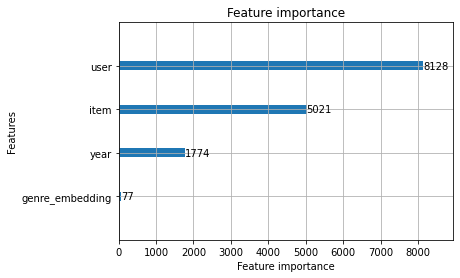

In [50]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 6. Inference

In [53]:
# 제출 파일에 들어갈 유저순서대로의 유저리스트 ex)[11, 14, 18, 25, ...]
# 1분정도 걸림
tmp = pd.read_csv('/opt/ml/input/data/eval/sample_submission.csv')
lst = list(tmp['user'].values)
user_list = []

for x in tqdm(lst):
    if x not in user_list:
        user_list.append(x)

100%|██████████| 313600/313600 [01:49<00:00, 2870.26it/s]


In [181]:
test_df.loc[(test_df['user'] == 14) & (test_df['item'] > 10000)]

,user,item,year,genre_embedding
319,14,52435,1966.0,-0.010442
322,14,33004,2005.0,-0.010269
332,14,33615,2005.0,-0.010369
334,14,59784,2008.0,-0.010392
336,14,32031,2005.0,-0.010401
347,14,56152,2007.0,-0.010486
356,14,68954,2009.0,-0.010482
358,14,30793,2005.0,-0.010387
368,14,53322,2007.0,-0.010271
375,14,31193,1977.0,-0.010688


In [183]:
sub.loc[(sub['item'] > 10000)]

,user,item
23411,359,32587
50714,741,47610
94929,1376,32587
94845,1376,33794
119707,1741,33794
...,...,...
9355541,137791,48516
9397005,138325,47610
9400618,138406,32587
9400515,138406,48516


In [52]:
# user_list

In [56]:
first_row = True

for user in tqdm(user_list):
    user_df = inference_df[inference_df['user']==user]
    
    y = model.predict(user_df[FEATS])
    y = torch.from_numpy(y)
    _, indices = torch.topk(y, 10)
    
    user_rec = user_df.iloc[indices,:]
    
    if first_row == True:
        result = user_rec
        first_row = False
    else:
        result = pd.concat([result, user_rec], axis=0, sort=False)

print("dataframe으로 만드는 중")
sub = pd.DataFrame(result, columns=["user","item"])
print("csv 파일로 내보내는 중")
sub.to_csv("EASE_LGBM.csv", index=False)
print("csv 파일로 내보내기 완료!")

100%|██████████| 31360/31360 [13:10<00:00, 39.68it/s]


dataframe으로 만드는 중
csv 파일로 내보내는 중
csv 파일로 내보내기 완료!


In [57]:
print(f"EASE 결과 item 중 item번호가 10000 미만 item 개수: {len(inference_df.loc[(inference_df['item'] < 10000)])}\n")
print(f"EASE 결과 item 중 item번호가 10000 이상 item 개수: {len(inference_df.loc[(inference_df['item'] >= 10000)])}\n")
print(f"LGBM 결과 item 중 item번호가 10000 미만 item 개수: {len(sub.loc[(sub['item'] < 10000)])}\n")
print(f"LGBM 결과 item 중 item번호가 10000 이상 item 개수: {len(sub.loc[(sub['item'] >= 10000)])}\n")
print("비율이 좀 이상한 것 같다..")

EASE 결과 item 중 item번호가 10000 미만 item 개수: 7038430

EASE 결과 item 중 item번호가 10000 이상 item 개수: 2369570

LGBM 결과 item 중 item번호가 10000 미만 item 개수: 293808

LGBM 결과 item 중 item번호가 10000 이상 item 개수: 19792

비율이 좀 이상한 것 같다..


In [230]:
# 대신 예측한 아이템 300개 내에선 10개 추출은 잘 되는 것 같다.
inf_res = set(inference_df.loc[(inference_df['user'] == 11)]['item'].values)

In [231]:
sub_res = set(sub.loc[(sub['user'] == 11)]['item'].values)

In [232]:
sub_res - inf_res

set()